In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark >& /dev/null 

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=US_Airline_Tweets.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_1} >& /dev/null 
fi

# Sentiment Analysis
This project will use a twitter US airline dataset to perform sentiment analysis.  Specifically, I will use twitter data to predict the sentiment of tweets related to peoples experience with an airline.

In [ ]:
# The purpose of the following boolean is to enable or disable grid search (see question 6a).  
# During grading we want to turn grid search off.  
# You should test your code with grid search set to False before submitting.
# Your notebook should run in its entirety without crashing when enable_grid is
# set to False before submitting.
enable_grid = False

In [ ]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Read US_Airline_Tweets.csv into a spark dataframe named `tweets_df`.  Drop all columns except airline_sentiment, airline, and text.  Drop rows in which the airline_sentiment column is labeled with a neutral sentiment.  Drop rows which contain NA / Null values in any column. Transform the airline_sentiment column such that a negative sentiment is equal to 0 and a positive sentiment is equal to 1.  This dataset has a lot more negative than positive tweets.  Balance the dataset such that the percentage of negative and positive tweets is roughly 50% each.  Your solution must **randomly sample** the dataset **without replacement** to perform balancing.  Determine and print the resulting percentage of positive and negative tweets in the dataframe such that it's easy for the graders to find and interpret your data.

In [ ]:
tweets_df = spark.read.format("csv")\
    .option("header", "true")\
    .load("US_Airline_Tweets.csv")
tweets_df.show()

+--------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+---------------+-------------------+-------------+--------------------+-----------+--------------------+--------------------+--------------------+
|            tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|           name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|      tweet_location|       user_timezone|
+--------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+---------------+-------------------+-------------+--------------------+-----------+--------------------+--------------------+--------------------+
|  570306133677760513|          neutral|                         1.0|          null|                     null|Virgi

In [ ]:
# Exclude columns other than 'airline_sentiment','airline','text'
tweets_df = tweets_df.select([c for c in tweets_df.columns if c in {'airline','airline_sentiment', 'text'}])

# Drop rows in which the airline_sentiment column is labeled with a neutral sentiment
tweets_df = tweets_df.where(fn.col('airline_sentiment') != 'neutral')

# Drop rows which contain NA / Null values in any column
tweets_df = tweets_df.dropna(how='any')

# Transform the airline_sentiment column into 0 and 1
from pyspark.sql.functions import regexp_replace
tweets_df = tweets_df.withColumn("airline_sentiment", regexp_replace("airline_sentiment","negative","0")).withColumn("airline_sentiment", regexp_replace("airline_sentiment","positive","1"))

In [ ]:
# Balance the dataset
tweets_df.groupBy('airline_sentiment').agg(fn.count('*')).show()

pos = tweets_df.where(fn.col("airline_sentiment")==1)

# Downsample neg
neg = tweets_df.where(fn.col("airline_sentiment")==0).sample(False, .25)

# Combine pos with downsampled neg
tweets_df = pos.union(neg)

+-----------------+--------+
|airline_sentiment|count(1)|
+-----------------+--------+
|                0|    9170|
|                1|    2363|
+-----------------+--------+



In [ ]:
tweets_pd = tweets_df.toPandas()
display(tweets_pd.head())
print(tweets_pd.shape)

,airline_sentiment,airline,text
0,1,Virgin America,@VirginAmerica plus you've added commercials t...
1,1,Virgin America,"@VirginAmerica yes, nearly every time I fly VX..."
2,1,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D"
3,1,Virgin America,"@VirginAmerica it was amazing, and arrived an ..."
4,1,Virgin America,@VirginAmerica I &lt;3 pretty graphics. so muc...


(4584, 3)


Pre-process the data by creating a pipeline named `tweets_pre_proc_pipe`. Your pipeline should tokenize, remove stop words, and do a TF-IDF transformation.  Fit and execute your pipeline, and create a new dataframe named `tweets_pre_proc_df`.  Print the shape of the resulting TF-IDF data such that it's easy for the graders to find and understand as num rows x num words. Based on the shape of the TF-IDF data, would you expect a logistic regression model to overfit?

In [ ]:
from pyspark.sql import functions as fn
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder


In [ ]:
# tokenize the text column
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

# load stop words
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

# stop words filter
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

# CountVectorizer
cv = CountVectorizer(minTF=1., minDF=5.)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

# idf
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

# pipeline
tweets_pre_proc_pipe = Pipeline(stages = [tokenizer, sw_filter, cv, idf]).fit(tweets_df)
tweets_pre_proc_df = tweets_pre_proc_pipe.transform(tweets_df)
tweets_pre_proc_df.show()

print('num words: ', len(tweets_pre_proc_pipe.stages[2].vocabulary))
print('num rows: ', tweets_pre_proc_df.count())

+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|airline_sentiment|       airline|                text|               words|            filtered|                  tf|               tfidf|
+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                1|Virgin America|@VirginAmerica pl...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,375,548...|(1337,[14,375,548...|
|                1|Virgin America|@VirginAmerica ye...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,18,41,4...|(1337,[14,18,41,4...|
|                1|Virgin America|@virginamerica We...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,592,928...|(1337,[14,592,928...|
|                1|Virgin America|@VirginAmerica it...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,34,44,7...|(1337,[14,34,44,7...|
|                1|V

In [ ]:
tweets_pre_proc_df.show(10)

+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|airline_sentiment|       airline|                text|               words|            filtered|                  tf|               tfidf|
+-----------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                1|Virgin America|@VirginAmerica pl...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,375,548...|(1337,[14,375,548...|
|                1|Virgin America|@VirginAmerica ye...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,18,41,4...|(1337,[14,18,41,4...|
|                1|Virgin America|@virginamerica We...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,592,928...|(1337,[14,592,928...|
|                1|Virgin America|@VirginAmerica it...|[@virginamerica, ...|[@virginamerica, ...|(1337,[14,34,44,7...|(1337,[14,34,44,7...|
|                1|V

Explanation: 

Since there're 4 times more number of rows than the number of words, I won't expect there's a logistic regression model to overfit.

Since IDF considers a word's frequency across all documents in a corpus, you can use IDF as a form of inference.  Examine the documentation for the spark ML object that you used to create TF-IDF scores and learn how to extract the IDF scores for words in the corpus.  The idf object in your pipeline has a `values` attribute and a `tolist()` method which can be used to extract IDF values.  Create a pandas dataframe containing the 5 most important IDF scores named `most_imp_idf`.  Create another pandas dataframe containing the 5 least important IDF scores named `least_imp_idf`.  Each dataframe shall have 2 columns named `word` and `idf_score`.  Explain in words your interpretation of what the IDF scores mean.

In [ ]:
# collect words
words = tweets_pre_proc_pipe.stages[2].vocabulary

# extract idf score from pipeline
idf_score = tweets_pre_proc_pipe.stages[-1].idf

# sort by idf score
idf_df = pd.DataFrame({'words': words, 'idf_score': idf_score})
least_imp_idf = idf_df.sort_values('idf_score').reset_index(drop=True).head(5)
most_imp_idf = idf_df.sort_values('idf_score', ascending=False).reset_index(drop=True).head(5)

In [ ]:
display(most_imp_idf)
display(least_imp_idf)

,words,idf_score
0,enough.,6.638786
1,line.,6.638786
2,area,6.638786
3,compensate,6.638786
4,;-),6.638786


,words,idf_score
0,@united,1.440289
1,@southwestair,1.720022
2,@usairways,1.735983
3,@americanair,1.738462
4,flight,1.786756


Explanation: 

idf score is used to score the relevance by a weighting system that assigns a weight to each word in a document based on it's tf(term frequency) and the idf(inverse document frequency). The words with higher scores of weight are deemed to be more significant.

Create a new recursive pipeline named `lr_pipe` which encapsulates `tweets_pre_proc_pipe` and adds a logistic regression model and any needed logistic regression support objects.  Use default logistic regression hyper parameters.  Fit lr_pipe using `tweets_df`.  Score the model using ROC AUC.  Report the resulting AUC such that it is easy for graders to find and interpret.

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
tweets_df = tweets_df.withColumn("airline_sentiment",fn.col("airline_sentiment").cast("float"))

In [ ]:
training_df, validation_df, testing_df = tweets_df.randomSplit([0.6, 0.3, 0.1], seed=123)

In [ ]:
[training_df.count(), validation_df.count(), testing_df.count()]

[2733, 1396, 455]

In [ ]:
lr = LogisticRegression().\
    setLabelCol('airline_sentiment').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

In [ ]:
lr_pipeline = Pipeline(stages=[tweets_pre_proc_pipe, lr]).fit(training_df)

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


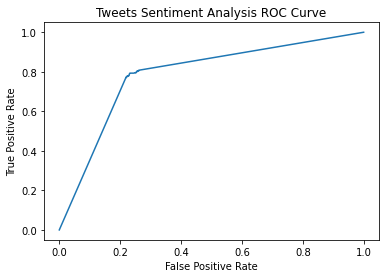

In [ ]:
# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = lr_pipeline.transform(validation_df)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('airline_sentiment','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['airline_sentiment'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Tweets Sentiment Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [ ]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = airline_sentiment)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.7779369627507163|
+------------------+



Create 2 pandas dataframes named `lr_pipe_df_neg` and `lr_pipe_df_pos`which contain 2 colunms: `word` and `score`.  Load the 2 dataframes with the top 10 words and logistic regression coefficients that contribute the most to negative and positive sentiments respectively. Analyze the 2 dataframes and describe if the words make sense.  Do the words look like they are really negative and positive?

In [ ]:
vocabulary = tweets_pre_proc_pipe.stages[2].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'score': weights})
coeffs_df.head()

num weights: 1337
num rows: 1396


,word,score
0,@united,-66.267407
1,flight,-1.937209
2,@southwestair,-53.265123
3,@usairways,-54.942783
4,@americanair,-54.124726


In [ ]:
# The most negative words are:
lr_pipe_df_neg = coeffs_df.sort_values('score').head(10)

In [ ]:
# The most positive words are:
lr_pipe_df_pos = coeffs_df.sort_values('score',ascending=False).head(10)

In [ ]:
# grading cell - do not modify
display(lr_pipe_df_neg)
display(lr_pipe_df_pos)

,word,score
1314,"oh,",-247.338608
402,leaving,-215.379381
931,plans,-213.681403
913,seating,-204.187755
1127,water,-199.959223
906,reward,-199.269327
491,hour.,-195.445908
689,sucks.,-192.084398
934,:,-187.142586
1204,sleeping,-186.651993


,word,score
1015,loving,333.748648
857,sweet,241.841370
982,listening,240.669507
8,thanks,237.907514
7,thank,227.496052
42,:),199.309858
883,report,194.909282
951,den,193.940731
273,excellent,190.188466
102,hope,189.241935


Explaination:
words in both lists don't make much sense. Only words like "thank","loving" in positive list make sense, while the rest of them would only make sense in specific context or don't sense at all.


The goal of this question is to try to improve the score from question 4 using an elastic net regularization grid search on a new pipeline named `lr_pipe_1`. lr_pipe_1 is the same as lr_pipe above but we would like you to create a new pipe for grading purposes only.  I'm not sure if it's possible to increase the score or not.  You will be graded on level of effort to increase the score in relation to other students in the class.  All of your grid search code should be inside the `if enable_grid` statement in the cell below.  The enable_grid boolean is set to true in a grading cell above.  If any of the grid search code executes outside of the if statement, you will not get full credit for the question.  We want the ability to turn off the grid search during grading.<br>

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

In [ ]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('airline_sentiment').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [ ]:

if enable_grid:
  # your grid search code here
  lr_pipe_1 = Pipeline(stages=[tweets_pre_proc_pipe, lr])

  # initiate
  grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()
  
  # iterate over the number of grid and train the models
  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_pipe_1.fit(training_df, grid[j])
      all_models.append(model)

  # calculate AUC scores for all trained models using validation data
  AUCs = [BinaryClassificationEvaluator(labelCol='airline_sentiment').\
            evaluate(m.transform(validation_df)) for m in all_models]
    
  # find the index of highest AUC score
  best_model_idx = np.argmax(AUCs)

  # find the best model
  best_model = all_models[best_model_idx]

  # locate the best model to find the best parameters
  print('Parameters of the best model: ', grid[best_model_idx])

pass

In [ ]:
AUCs

[0.8516039166362995,
 0.8516352622649559,
 0.8516352622649571,
 0.8516039166362984,
 0.8516039166362995,
 0.8516039166363005,
 0.8516352622649571,
 0.8516039166362985,
 0.8516039166363011]


Build a new pipeline named `lr_pipe_2` which uses the optimized model parameters from the grid search in question 6a above (the best model).  Create 2 variables named alpha and lambda and assign to them the best alpha and lambda produced by the grid search by hard coding the values. Fit and transform lr_pipe_2.  Compare AUC scores between lr_pipe_2 with lr_pipe in question 4.  Create a pandas dataframe named `comapre_1_df` which encapsulates the comparison data.  comapre_1_df Shall have 2 columns: `model_name` and `auc_score`.

In [ ]:
# your optimized model code here
lambda_par = 0.02
alpha_par = 0.25

# fit and transform lr_pipe_2
lr_2 = LogisticRegression().\
        setLabelCol('airline_sentiment').\
        setFeaturesCol('tfidf').\
        setRegParam(alpha_par).\
        setMaxIter(100).\
        setElasticNetParam(lambda_par)

lr_pipe_2 = Pipeline(stages=[tweets_pre_proc_pipe, lr_2]).fit(training_df)

# report AUC score with testing data
evaluator = BinaryClassificationEvaluator(labelCol='airline_sentiment')
AUC_score_2 = evaluator.evaluate(lr_pipe_2.transform(testing_df))
print('AUC Score: ', AUC_score_2)

compare_score = {'model_name':['lr_pipe', 'lr_pipe_2'], 'auc_score':[AUCs, AUC_score_2]}
comapre_1_df = pd.DataFrame.from_dict(compare_score)

AUC Score:  0.9317759181775931


In [ ]:
display(comapre_1_df)

,model_name,auc_score
0,lr_pipe,"[0.8516039166362995, 0.8516352622649559, 0.851..."
1,lr_pipe_2,0.931776



Perform inference on lr_pipe_2.  Write code to report how many words were eliminated from the best model in question 6b above (if any) as compared to the model in question 4 above.  Make sure your output is easy for the graders to find and interpret.

Describe in words how feature selection is performed using elastic net regularization.

In [ ]:
words1 = coeffs_df.query('score ==  0.0').shape
words1

vocabulary = tweets_pre_proc_pipe.stages[2].vocabulary
weights_2 = lr_pipe_2.stages[-1].coefficients.toArray()

coeffs_df_2 = pd.DataFrame({'word': vocabulary, 'score': weights_2})
words2 = coeffs_df_2.query('score ==  0.0').shape

In [ ]:
print("Number of words eliminated: ", words2[0] - words1[0])

Number of words eliminated:  0


Explaination:

Since there're a few features are actually useful while approximately 95% of words are not needed to achieve a better performance than all previous models, elastic net refularization tend to reduce the useless features’ weights down to zero.




Perform the same inference analysis that you did in question 5 but name the data frames `lr_pipe_df_neg_1` and `lr_pipe_df_pos_1`.  Compare the word importance results with the results in question 5.  Do the most positive and most negative words produced by using regularization better reflect positive and negative sentiment than the most positive and negative words produced by the model that did not use regularization?

In [ ]:
vocabulary = lr_pipe_2.stages[0].stages[2].vocabulary
weights = lr_pipe_2.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'score': weights})
coeffs_df.head()

num weights: 1337
num rows: 1396


,word,score
0,@united,-0.072229
1,flight,-0.082672
2,@southwestair,0.130469
3,@usairways,-0.147123
4,@americanair,-0.056664


In [ ]:
# The most negative words are:
lr_pipe_df_neg_1 = coeffs_df.sort_values('score').head(10)

In [ ]:
# The most positive words are:
lr_pipe_df_pos_1 = coeffs_df.sort_values('score',ascending=False).head(10)

In [ ]:
display(lr_pipe_df_neg_1)
display(lr_pipe_df_pos_1)

,word,score
124,worst,-0.170170
3,@usairways,-0.147123
21,hold,-0.143898
10,cancelled,-0.137058
123,doesn't,-0.136267
332,money,-0.132857
36,don't,-0.129574
1314,"oh,",-0.125636
931,plans,-0.124357
689,sucks.,-0.121320


,word,score
7,thank,0.293486
8,thanks,0.289665
31,thanks!,0.191760
42,:),0.161065
79,thanks.,0.153957
28,love,0.153102
13,great,0.149307
5,@jetblue,0.135083
24,you!,0.133168
2,@southwestair,0.130469


Explaination:
The most positive and negative words produced by regularization make better sense.


Precision recall plots are very similar to receiver operating characteristic (ROC) curves.  The high level steps for creating a precision recall curve are the same as the steps needed to create a ROC curve as outlined in lecture. Learn about [precision recall curves](https://en.wikipedia.org/wiki/Precision_and_recall).  Create a precision recall plot for the best model in question 6.  Describe what axes are the same / different between the precision recall curve and the ROC curve.

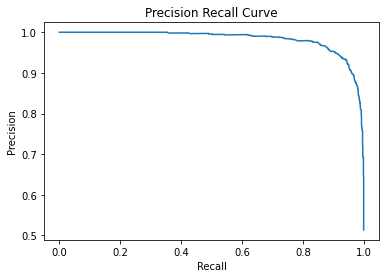

In [ ]:
pr = lr_pipe_2.stages[-1].summary.pr.toPandas()

#create precision and recall curve
plt.plot(pr['recall'],pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision Recall Curve")
plt.show()

Explaination:

In ROC Curve, the true positive rate (TPR, y-axis) is plotted against the false positive rate (FPR, x-axis). In Precision-Recall Curves Precision-recall curves plot the positive predictive value (PPV, y-axis) against the true positive rate (TPR, x-axis). 


Design and implement a method to rank the airlines in your dataset from best to worst.  Your solution can use model predictions or inference or both to perform this task. Implement your ranking algorithm in spark.  Create a spark dataframe named airline_rankings.  airline_rankings Shall have 3 columns: airline_name, num_reviews, and ranking.  Load the num_reviews column with the number of reviews associated with the airline.  Load the ranking column with your rank calculation result.  Sort airline rankings from best to worst (best at head, worst at tail).  

Describe in words how your algorithm works in clear easy to understand language.  We will take points off for descriptions that are not clearly stated and easy to follow.  We don't expect to have to reverse engineer your code understand how your algorithm works.

In [ ]:
# How many reviews each airline has                              
num_reviews_each_airline = lr_pipe_2.transform(tweets_df).groupby('airline').agg(fn.count('*')) 
num_reviews_each_airline = num_reviews_each_airline.withColumnRenamed('count(1)','num_reviews').withColumnRenamed('airline','airline_name')  

# Define rank by average prediction
ave_predict = lr_pipe_2.transform(tweets_df).select('airline_sentiment', 'airline', 'text').\
              groupby('airline').\
              agg(fn.avg('airline_sentiment').alias('ave_prediction'))      
ave_predict = ave_predict.withColumnRenamed('airline','airline_name') 

# Join two dataframes
airline_rankings = num_reviews_each_airline.\
                   join(ave_predict, how='inner', on='airline_name').toPandas()

# Get ranking
airline_rankings['ranking'] = airline_rankings['ave_prediction'].rank(ascending=False)
airline_rankings.drop('ave_prediction', axis=1, inplace=True)
airline_rankings.sort_values(by=['ranking'], inplace=True)




Algorithm description here:

> Indented block



The algorithm above first created two dataframes: one is the number of reviews by each airline, another one is the average prediction of each airline, with the same key that would be joined on. Then it got the ranking of column 'ave_prediction' by using rank() in pandas, by which we can sort later.

In [ ]:
display(airline_rankings.head())
display(airline_rankings.tail())

,airline_name,num_reviews,ranking
1,Virgin America,199,1.0
0,Delta,763,2.0
4,Southwest,851,3.0
2,United,1138,4.0
5,American,814,5.0


,airline_name,num_reviews,ranking
0,Delta,763,2.0
4,Southwest,851,3.0
2,United,1138,4.0
5,American,814,5.0
3,US Airways,819,6.0


# tip
Make sure to set enable_grid to False in the grading cell above and run the notebook in its entirety before submitting to verify that there are no runtime erros.  